In [1]:
import numpy as np

from Solver import mesh_less, crank_nicolson_fd
from Utilz import F_v0, F_v0_x, diff, eval_F

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec

In [2]:
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

In [3]:
def mu(x, t, prms):
    T = prms[0]
    sigma = prms[1]
    a = prms[2]
    v0 = prms[3]
    T_infty = prms[4]
    
    return T*T_infty/(a*(T_infty - T*t)) * (a/(2*T_infty) * (2*x-1) - v0)

In [4]:
def g(x, t, prms, max_k=20):
    T = prms[0]
    sigma = prms[1]
    a = prms[2]
    v0 = prms[3]
    T_infty = prms[4]
    
    sigma_hat = (T*T_infty*sigma**2)/(2*a**2*(T_infty-T))

    if t == 0:
        return 0
    elif np.isclose(mu(x, t, prms) - mu(0, 0, prms), 0):
        return 0
    else:
        return (mu(x, t, prms) - mu(0, 0, prms)) * F_v0_x(x, t, sigma_hat, mu(0, 0, prms), max_k)

# Computation Time: 

In [5]:
sigma = 1
a = 1.5
T = 0.5
v0 = 1.1
T_infty = 2

prms = [T, sigma, a, v0, T_infty]

kappa = (T*T_infty*sigma**2)/(2*a**2*(T_infty-T))

In [6]:
# %time for _ in range(10): mesh_less(kappa, prms, mu, g, M=9, dt = 0.01, max_k=20)

In [7]:
# %time for _ in range(10): crank_nicolson_fd(kappa, prms, mu, g, M=100, N=100, max_k=20)

# Error Estimation:

In [8]:
sigma = 1
a = 1.5
v0 = 1.1
T_infty = 2

M_ml_1 = 5
M_ml_2 = 8
M_fd_ex = 100

time_step = 5
time_step_ex = 100

max_k = 20

x = 0.5
theta = 0.3

for T in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]:
    prms = [T, sigma, a, v0, T_infty]
    kappa = (T*T_infty*sigma**2)/(2*a**2*(T_infty-T))
    
    ml_1 = mesh_less(kappa, prms, mu, g, theta=theta, M=M_ml_1, N=time_step, max_k=max_k, eps=1)
    ml_2 = mesh_less(kappa, prms, mu, g, theta=theta, M=M_ml_1, N=time_step, max_k=max_k, eps=5)
    ml_3 = mesh_less(kappa, prms, mu, g, theta=theta, M=M_ml_1, N=time_step, max_k=max_k, eps=8)
    
    ml_4 = mesh_less(kappa, prms, mu, g, theta=theta, M=M_ml_2, N=time_step, max_k=max_k, eps=1)
    ml_5 = mesh_less(kappa, prms, mu, g, theta=theta, M=M_ml_2, N=time_step, max_k=max_k, eps=5)
    ml_6 = mesh_less(kappa, prms, mu, g, theta=theta, M=M_ml_2, N=time_step, max_k=max_k, eps=8)
    
    fd_ex = crank_nicolson_fd(kappa, prms, mu, g, theta=theta, M=M_fd_ex, N=time_step_ex, max_k=max_k)
    
    exact = interp1d(fd_ex['X'][1:-1], fd_ex['sol'], 'quadratic')
    
    err_ml_1 = np.abs(eval_F(ml_1, x) - exact(x))
    err_ml_2 = np.abs(eval_F(ml_2, x) - exact(x))
    err_ml_3 = np.abs(eval_F(ml_3, x) - exact(x))
    
    err_ml_4 = np.abs(eval_F(ml_4, x) - exact(x))
    err_ml_5 = np.abs(eval_F(ml_5, x) - exact(x))
    err_ml_6 = np.abs(eval_F(ml_6, x) - exact(x))
    
    print('T = {}, ML_1_ERR = {}, ML_2_ERR = {}, and ML_3_ERR = {}'.format(T, err_ml_1, err_ml_2, err_ml_3))
    print('\t ML_4_ERR = {}, ML_5_ERR = {}, and ML_6_ERR = {}'.format(err_ml_4, err_ml_5, err_ml_6))
    print("\t\t\t\t....................................")

T = 0.1, ML_1_ERR = 0.0005611886989649456, ML_2_ERR = 0.0004496945429906833, and ML_3_ERR = 0.00021978631589936008
	 ML_4_ERR = 0.0003794244860964163, ML_5_ERR = 0.0004093093738645123, and ML_6_ERR = 0.0003981195269673809
				....................................
T = 0.2, ML_1_ERR = 0.0005231162091254155, ML_2_ERR = 0.0005032175144614251, and ML_3_ERR = 0.005075298698857587
	 ML_4_ERR = 0.0006754546661957156, ML_5_ERR = 0.0005540545190727726, and ML_6_ERR = 0.0006010934500896362
				....................................
T = 0.3, ML_1_ERR = 0.001941630834850546, ML_2_ERR = 0.0016255096519355687, and ML_3_ERR = 0.008758603020629427
	 ML_4_ERR = 0.0016508083841282294, ML_5_ERR = 0.0016746281698845449, and ML_6_ERR = 0.0017127614885192669
				....................................
T = 0.4, ML_1_ERR = 0.0025593028626820225, ML_2_ERR = 0.0024757979570891944, and ML_3_ERR = 0.01015696331472035
	 ML_4_ERR = 0.0023422354159554626, ML_5_ERR = 0.002453909468090338, and ML_6_ERR = 0.002487009804172463

# Convergence Rate & Model Behavior:

In [9]:
def eval_error(kappa, prms, mu, g, eps):
    ml_4 = mesh_less(kappa, prms, mu, g, theta=0.5, M=5, N=5, max_k=0, eps=eps)
    ml_8 = mesh_less(kappa, prms, mu, g, theta=0.5, M=10, N=5, max_k=20, eps=eps)
    ml_16 = mesh_less(kappa, prms, mu, g, theta=0.5, M=20, N=5, max_k=20, eps=eps)
    ml_32 = mesh_less(kappa, prms, mu, g, theta=0.5, M=40, N=5, max_k=20, eps=eps)
    ml_64 = mesh_less(kappa, prms, mu, g, theta=0.5, M=80, N=5, max_k=20, eps=eps)
    
    xx = np.linspace(0, 1, 20)
    
    err1 = np.sum((eval_F(ml_4, xx) - eval_F(ml_8, xx))**2)
    err2 = np.sum((eval_F(ml_8, xx) - eval_F(ml_16, xx))**2)
    err3 = np.sum((eval_F(ml_16, xx) - eval_F(ml_32, xx))**2)
    err4 = np.sum((eval_F(ml_32, xx) - eval_F(ml_64, xx))**2)
    
    err = np.array([err1, err2, err3, err4])
    
    return err

In [10]:
sigma = 1
a = 1.5
v0 = 1.1
T_infty = 2
T = 1

prms = [T, sigma, a, v0, T_infty]
kappa = (T*T_infty*sigma**2)/(2*a**2*(T_infty-T))

err_eps1 = eval_error(kappa, prms, mu, g, 7)
err_eps2 = eval_error(kappa, prms, mu, g, 10)
err_eps3 = eval_error(kappa, prms, mu, g, 13)

In [11]:
M_ml = 9

xx = np.linspace(0, 1, 100)
TT = np.linspace(0.05, 1, 100)

F = np.zeros((len(TT), len(xx)))

for n in range(len(TT)):
    
    prms = [TT[n], sigma, a, v0, T_infty]
    kappa = (TT[n]*T_infty*sigma**2)/(2*a**2*(T_infty-TT[n]))
    
    ml = mesh_less(kappa, prms, mu, g, theta=0.5, M=M_ml, N=20, max_k=20)
    F[n, :] = eval_F(ml, xx) + F_v0(xx, 1, kappa, mu(0, 0, prms))

# Plotting:

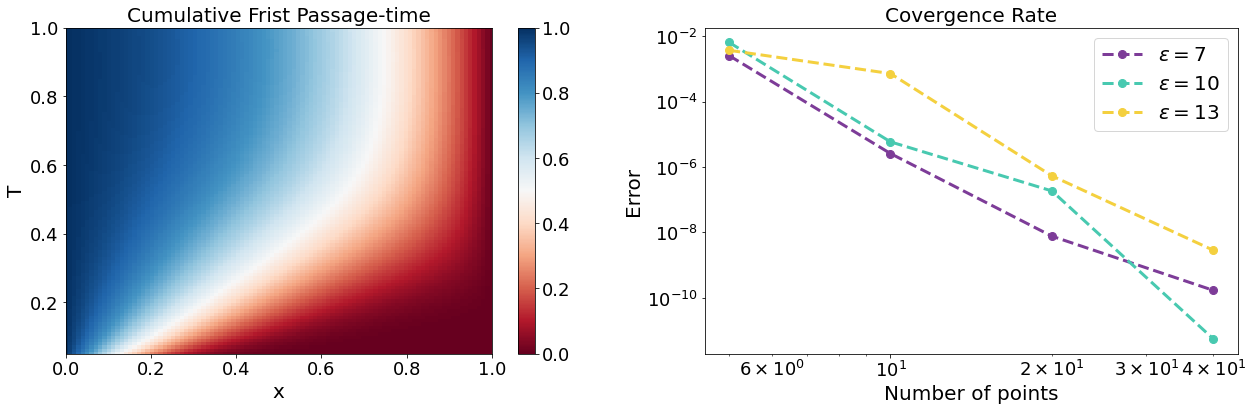

In [15]:
fig = plt.figure(figsize=(21, 6));
gs = gridspec.GridSpec(nrows=1, ncols=2)

ax0 = fig.add_subplot(gs[0, 0])
x, t = np.meshgrid(xx, TT)

c = ax0.pcolormesh(x, t, F, cmap='RdBu', vmin=F.min(), vmax=F.max())
ax0.set_title('Cumulative Frist Passage-time')

ax0.axis([x.min(), x.max(), t.min(), t.max()])
fig.colorbar(c, ax=ax0)

plt.xlabel('x')
plt.ylabel('T')

ax1 = fig.add_subplot(gs[0, 1])
plt.loglog([5, 10, 20, 40], err_eps1, '--o', linewidth=3, markersize=8, c='#7D3C98', label=r'$\epsilon=7$');
plt.loglog([5, 10, 20, 40], err_eps2, '--o', linewidth=3, markersize=8, c='#48C9B0', label=r'$\epsilon=10$');
plt.loglog([5, 10, 20, 40], err_eps3, '--o', linewidth=3, markersize=8, c='#F4D03F', label=r'$\epsilon=13$');
plt.xlabel('Number of points');
plt.ylabel('Error');
plt.title('Covergence Rate');
plt.legend()

plt.savefig('_plots/LC.png')
plt.savefig('_plots/LC.pdf')